In [1]:
'''

SNR 分别计算STD和ODD的SNR，然后相减，或者检验
和ASSR不一样，是需要求差异才有意义。始终都是差异波。

ERSP直接能量相减，然后才是统计（和0比，或者和DD儿童的比）
'''
import  mne
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np

In [2]:

# data_path = 'E:\实验\阅读困难\数据处理\pre1nanshi\data\\6epoch_equalization_oddball\\'
data_path = 'E:\Python LYW\RSA\spaced_learning\pre10\\analysis\data\\6epoch_clean\\'

list_O_ids = [
    'prex006','prex009','prex010','prex011','prex012',
    'prex015','prex016','prex017','prex018','prex019','prex022','prex023',
    'prex027','prex028',
    'prex033','prex037','prex038','prex040',
    'prex041','prex042','prex044','prex045',
    'prex046','prex047','prex049','prex050','prex052','prex051'
]
#去掉了 5和9被
list_M_ids = [
    'prex006M','prex009M','prex010M','prex011M','prex012M',
    'prex015M','prex016M','prex017M','prex018M','prex019M','prex022M','prex023M',
    'prex027M','prex028M',
    'prex033M','prex037M','prex038M','prex040S',
    'prex041M','prex042M','prex044M','prex045M'
    ,'prex046M','prex047M','prex049S','prex050M','prex052M','prex051M'

]

list_S_ids = [
    'prex006S','prex009S','prex010S','prex011S','prex012S',
    'prex015S','prex016S','prex017S','prex018S','prex019S','prex022S','prex023S',
    'prex027S','prex028S'
    ,'prex033S','prex037S','prex038S','prex040M'
    ,'prex041S','prex042S','prex044S','prex045S'
    ,'prex046S','prex047S','prex049M','prex050S','prex052S','prex051S'
]

#

sub_id = list_O_ids[0]
#就是单个被试的数据啊。。
epochs_S = mne.read_epochs(data_path+sub_id+'S-epo.fif')
epochs_M = mne.read_epochs(data_path+sub_id+'M-epo.fif')
epochs_O = mne.read_epochs(data_path+sub_id+'-epo.fif')



Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex006S-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex006M-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex006-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\SilverBullet\AppData\Roaming\Python\Python39\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


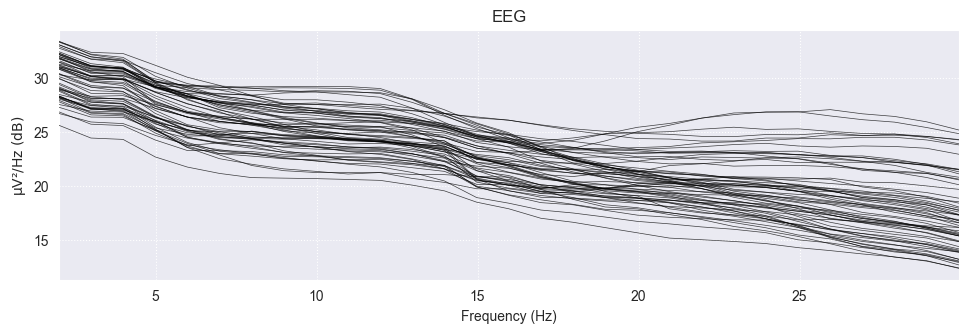

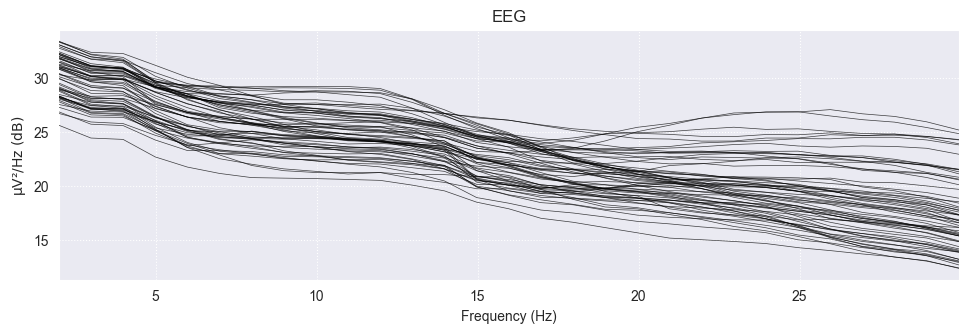

In [3]:
epochs_S.plot_psd(fmin=1.,fmax=30.,average=False,spatial_colors=False)
# epochs_O.plot_psd(fmin=1.,fmax=30.,average=True,spatial_colors=False)

In [11]:
'''
根据mne分析VSSR的脚本
https://mne.tools/stable/auto_tutorials/time-freq/50_ssvep.html?highlight=snr

'''

tmin = 0.
tmax = 0.8
fmin = 1.
fmax = 40.
sfreq = epochs_O.info['sfreq']

psds_O, freqs = mne.time_frequency.psd_welch(
    epochs_O,
    #问题这里设置成多少好呢？
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)

psds_M,freqs = mne.time_frequency.psd_welch(
    epochs_M,
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)

psds_S,freqs = mne.time_frequency.psd_welch(
    epochs_S,
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)

<decorator-gen-201>:4: FutureWarning: NOTE: psd_welch() is a deprecated function. Function psd_welch() is deprecated; for Raw/Epochs/Evoked instances use spectrum = instance.compute_psd(method="welch") instead, followed by spectrum.get_data(return_freqs=True)..


In [12]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

snrs_O = snr_spectrum(psds_O, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=0)
snrs_M = snr_spectrum(psds_M, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=0)
snrs_S = snr_spectrum(psds_S, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=0)

In [13]:
'''
需要按照channel平均之后做差
'''
%matplotlib qt

fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_O_plot = 10 * np.log10(psds_O)
psds_S_plot = 10 * np.log10(psds_S)
psds_M_plot = 10 * np.log10(psds_M)

# PSD  作图准备 平均值 和 标准差
# 你想要比较的是S-O M-O
# 按两个方向平均 就剩下一个维度了--频率维度
psds_mean = psds_S_plot.mean(axis=(0, 1))[freq_range] -  psds_O_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_S_plot.std(axis=(0, 1))[freq_range] - psds_O_plot.std(axis=(0, 1))[freq_range]

axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs_S.mean(axis=(0, 1))[freq_range] - snrs_O.mean(axis=(0, 1))[freq_range]
snr_std = snrs_S.std(axis=(0, 1))[freq_range] - snrs_O.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show()

In [14]:
'''
接着看一下时频分析情况
https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-20-sensors-time-frequency-py

averagebool, default True
If False return an EpochsTFR containing separate TFRs for each epoch. If True return an AverageTFR containing the average of all TFRs across epochs.
函数参数设置。
'''
#num似乎纵轴，频段的个数，要分得更细的话，就增大一些。
freqs = np.logspace(*np.log10([1, 50]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency

# 你想让他们进行相减 但是这里的power已经被平均过了
# 如果是每个被试的epochs单独拿出来算power，然后呢？
# 还是平均power的好，不然就是以试次为单位了，所以才会没有ITC。
# 应该是先计算出两个条件的平均power，然后再来相减。最后才是组间统计。
power,itc = tfr_morlet(epochs_O, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1, average=True)
power1, itc1 = tfr_morlet(epochs_S, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1, average=True)


In [8]:
# power之间可以直接相减吗？不知道其父类是不是有这个功能。
#power_m = power - power1 直接相减报错 - 考虑降级到ndarray进行相减。
# to_data_frame 函数
# 但是结果挺奇怪的。为什么只有二维。
import pandas
#datandarray, shape (n_epochs, n_channels, n_freqs, n_times) 直接取用.data就行
#所有被试的
nd_power = power.data
nd_power1 = power1.data
# 直接相减有问题的。
# 如果不相减，那就是做统计T了，感觉应该也行。
nd_power_m = nd_power1 - nd_power

In [9]:
print(nd_power)

[[[9.41273724e-11 1.02057668e-10 1.18770913e-10 ... 1.99739047e-09
   2.03852374e-09 2.06621719e-09]
  [1.76454904e-10 1.89151910e-10 2.08488440e-10 ... 1.72253310e-09
   1.74505346e-09 1.75642023e-09]
  [3.07690723e-10 3.29837516e-10 3.54956247e-10 ... 1.24627627e-09
   1.23817229e-09 1.22263865e-09]
  ...
  [1.95280780e-10 2.08260977e-10 2.20349853e-10 ... 2.51798467e-10
   2.39469541e-10 2.26115725e-10]
  [1.49313583e-10 1.62765505e-10 1.76257214e-10 ... 1.69340582e-10
   1.58577614e-10 1.47449104e-10]
  [3.90497664e-12 3.87285027e-12 3.79734174e-12 ... 3.88781101e-12
   3.99378132e-12 4.05605489e-12]]

 [[7.81368747e-11 8.25909220e-11 9.40059420e-11 ... 1.94602064e-09
   1.96789157e-09 1.97386362e-09]
  [1.43652593e-10 1.53022154e-10 1.67602173e-10 ... 1.64606499e-09
   1.65306671e-09 1.64746273e-09]
  [2.40020290e-10 2.57833670e-10 2.77959829e-10 ... 1.11108434e-09
   1.09736813e-09 1.07631352e-09]
  ...
  [1.56205750e-10 1.66456163e-10 1.76066853e-10 ... 2.04126191e-10
   1.91302

Applying baseline correction (mode: zscore)


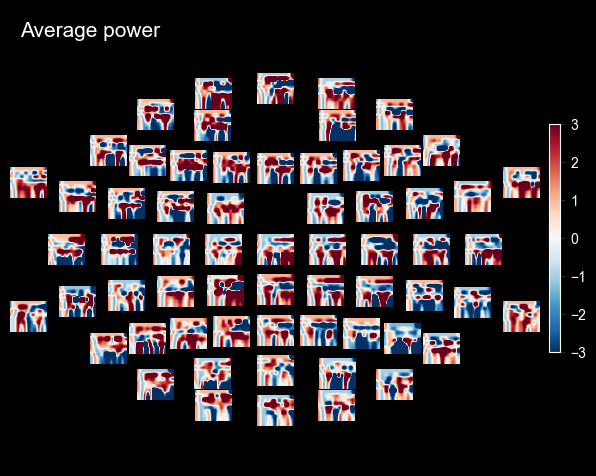

In [10]:

%matplotlib qt
# 把data幅值给数据，方便作图。
power.data = nd_power_m
power.plot_topo(baseline=(-0.2, 0), mode='zscore', title='Average power',vmin = -3,vmax = 3)


In [13]:
power.plot([33], baseline=(-0.2, 0), mode='logratio', title=power.ch_names[33])
plt.show()

Applying baseline correction (mode: logratio)


I:\ProgramData\Anaconda3\envs\mne\lib\site-packages\mne\baseline.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


In [23]:
'''
地形图
'''
fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0, tmax=0.8, fmin=1, fmax=30,
                   baseline=(-0.2, 0), mode='logratio', axes=axis[0],
                   title='all', show=False)
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: logratio)


In [34]:
'''
单个被试的ITC计算和作图
原理和power应该是一样的
'''

nd_itc = itc.data
nd_itc1 = itc1.data

# 直接相减有问题的。 m代表 minus
nd_itc_m = nd_itc1 - nd_itc
itc_m = itc.copy()
itc_m.data = nd_power_m
itc_m.plot_topo(baseline=(-0.2, 0), mode='logratio', title='Average power')
itc_m.plot([33], baseline=(-0.2, 0), mode='logratio', title=power.ch_names[33])

Applying baseline correction (mode: logratio)


I:\ProgramData\Anaconda3\envs\mne\lib\site-packages\mne\baseline.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


Applying baseline correction (mode: logratio)


[<Figure size 640x480 with 2 Axes>]